Analyse some recent GOLEM shots from 25000 to 26023. 

# Getting data

The dataset has been created from the [GolSQL tool](http://golem.fjfi.cvut.cz/utils/miner), with the follow URL used to generate the dataset:


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

In [25]:
dataset = pd.read_csv('close_shots.txt', delimiter='\s+', index_col='shots')

In [26]:
dataset.head()

,pressure_initial,cbd,cb,breakdown_field,tb,electron_temperature_max,ucd,tcd,input_power_mean,breakdown_voltage,...,breakdown_rate_err,ubd,plasma_current_mean,breakdown_probability,discharge_aborted,pressure_chamber,loop_voltage_mean,ccd,loop_voltage_max,ub
shots,,,,,,,,,,,,,,,,,,,,,
20000,10.275,0.0036,0.0675,0.086171,0.005,19.339,500.0,0.006,17588.0,10.501,...,NaN,0.0,1416.8,NaN,NaN,NaN,12.4140,0.0135,15.140,1000.0
20001,10.275,0.0036,0.0675,NaN,0.005,NaN,400.0,0.011,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0135,11.105,600.0
20002,10.236,0.0036,0.0675,0.164820,0.005,16.332,400.0,0.011,10095.0,10.225,...,NaN,0.0,1067.9,NaN,NaN,NaN,9.4531,0.0135,13.707,600.0
20003,10.275,0.0036,0.0675,0.064730,0.005,21.470,500.0,0.006,16610.0,11.843,...,NaN,0.0,1610.7,NaN,NaN,NaN,10.3120,0.0135,18.776,600.0
20004,10.275,0.0036,0.0675,0.193450,0.005,16.559,400.0,0.013,10209.0,10.286,...,NaN,0.0,1083.8,NaN,NaN,NaN,9.4195,0.0135,13.575,600.0


# Cleaning data

Filter bad shots from the dataset, as adviced in the [GOLEM DataMining Page](http://golem.fjfi.cvut.cz/wiki/Handling/DataMining/data_mining)

In [27]:
print(len(dataset)) # number of shot before cleaning 

6018


In [28]:
# Drop failed plasma
dataset = dataset.dropna(subset=['plasma'])

# Drop plasma longer than 25 ms
dataset = dataset.drop(dataset[dataset['plasma_life'] > 25e-3].index)

# Drop loop voltage below than 5V
dataset = dataset.drop(dataset[dataset['loop_voltage_max'] < 5].index)

# Drop pressure larger than 100mPa
dataset = dataset.drop(dataset[dataset['pressure'] > 100].index)

# number of shot after cleaning
print(len(dataset)) 

5687


## Which parameters to maximize the plasma current?

In [144]:
# get the longest shots
dataset_ip = dataset[['ub', 'ucd', 'tcd', 'pressure_request','plasma_current_mean', 'input_power_mean']].dropna()
# keep only the pressure request=20 (majority) to remove a dimension
dataset_ip = dataset_ip[dataset_ip['pressure_request'] == 20]
# keep only the tcd=600 µs (majority) to remove a dimension
dataset_ip = dataset_ip[dataset_ip['tcd'] == 0.006]
dataset_ip = dataset_ip.drop(['tcd','pressure_request'], axis=1)

dataset_ip.sort_values('plasma_current_mean', ascending=False).head()


,ub,ucd,plasma_current_mean,input_power_mean
shots,,,,
25954,1100.0,600.0,6591.1,41242.0
23593,1100.0,650.0,6147.4,47340.0
25972,1100.0,500.0,5983.8,29970.0
24822,1050.0,700.0,5943.9,56149.0
23594,1100.0,600.0,5911.2,41354.0


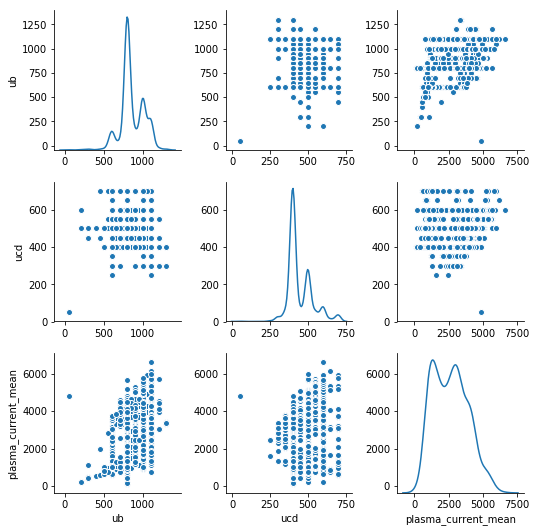

In [146]:
seaborn.pairplot(dataset_ip[['ub', 'ucd','plasma_current_mean']], diag_kind='kde')

In [189]:
# make the average of similar parameters
dataset_ip_avg = dataset_ip.groupby(['ucd','ub']).mean().reset_index()
dataset_ip_avg.head(10)

,ucd,ub,plasma_current_mean,input_power_mean
0,50.0,50.0,4824.40,22706.000000
1,250.0,600.0,1600.90,8415.600000
2,250.0,1100.0,2463.75,9222.000000
3,300.0,600.0,1582.55,7929.750000
4,300.0,700.0,2567.60,13687.000000
5,300.0,900.0,2769.10,10058.000000
6,300.0,1000.0,2348.40,11470.666667
7,300.0,1100.0,2912.53,12039.500000
8,300.0,1200.0,3040.20,12066.666667
9,300.0,1300.0,3368.20,13176.000000


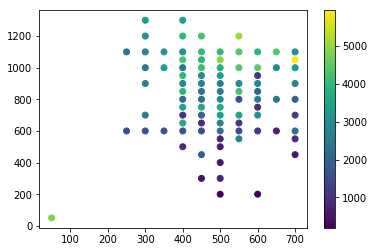

In [194]:
fig, ax = plt.subplots()
cax1=ax.scatter(x=dataset_ip_avg['ucd'], y=dataset_ip_avg['ub'], c=dataset_ip_avg['plasma_current_mean'])
cb1=plt.colorbar(cax1)


# Which parameters to improve the plasma lifetime?

In [168]:
# get the longest shots
dataset_lt = dataset[['ub', 'ucd', 'tcd', 'pressure_request','plasma_life']].dropna()
dataset_lt.sort_values('plasma_life', ascending=False).head()


,ub,ucd,tcd,pressure_request,plasma_life
shots,,,,,
25341,1300.0,400.0,0.005,20,0.02498
23800,1300.0,400.0,0.005,20,0.02498
25483,1300.0,400.0,0.005,20,0.02494
24292,1300.0,450.0,0.005,20,0.02494
25479,1300.0,400.0,0.005,20,0.02486


According to the GOLEM documentation, the following parameters can be tuned for each plasma shot:

 - Toroidal Magnetic Field, set by $U_B$
 - Current Drive, set bu $U_{CD}$
 - Time delay for Current Drive, $\tau_{CD}$
 - Filling Pressure, $p_{WG}$ [mPa]
 
So let's look for the set of parameters which maximize the plasma duration

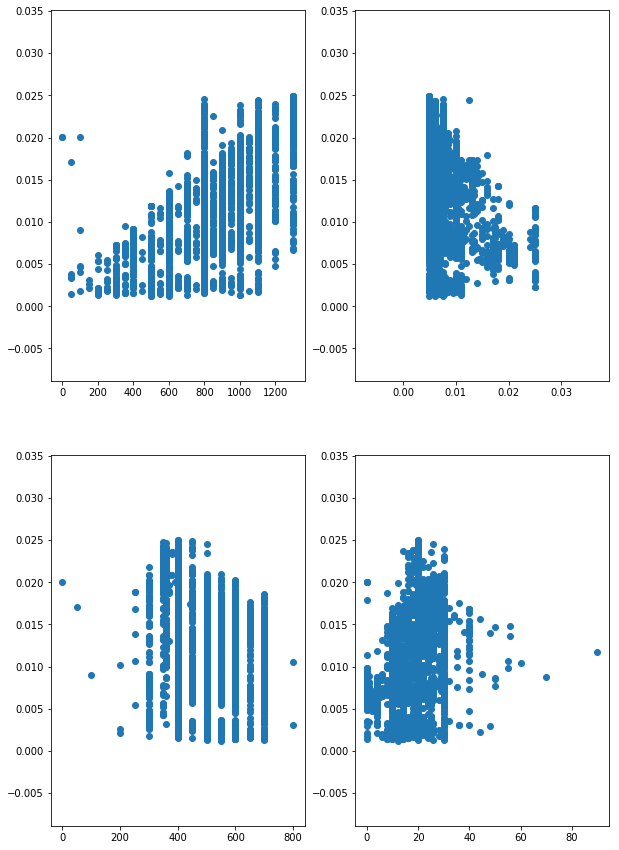

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(10,15))
ax[0,0].scatter(dataset_lt['ub'], dataset_lt['plasma_life'])
ax[1,0].scatter(dataset_lt['ucd'], dataset_lt['plasma_life'])
ax[0,1].scatter(dataset_lt['tcd'], dataset_lt['plasma_life'])
ax[1,1].scatter(dataset_lt['pressure_request'], dataset_lt['plasma_life'])

The question is : what is the set of parameters $\{u_B, u_{CD}, \tau_{CD}, p\}$ which maximize the plasma duration ? 

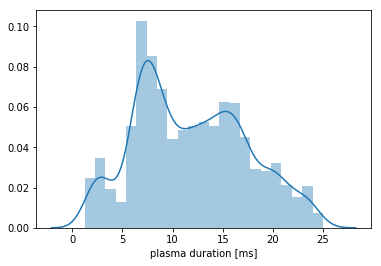

In [37]:
seaborn.distplot(dataset_lt['plasma_life']*1e3, axlabel='plasma duration [ms]')

So, how to produce a plasma duration larger than 15 ms ?

In [39]:
longest_shots = dataset_lt[dataset_lt['plasma_life'] > 15e-3]

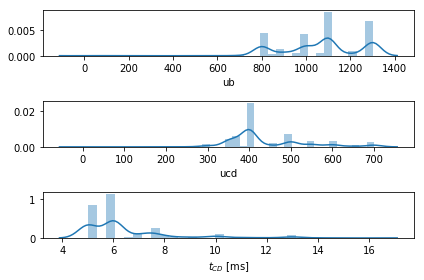

In [40]:
fig, ax = plt.subplots(3,1)
seaborn.distplot(longest_shots['ub'], ax=ax[0])
seaborn.distplot(longest_shots['ucd'], ax=ax[1])
seaborn.distplot(longest_shots['tcd']*1e3, ax=ax[2], axlabel='$t_{CD}$ [ms]')
fig.tight_layout()

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


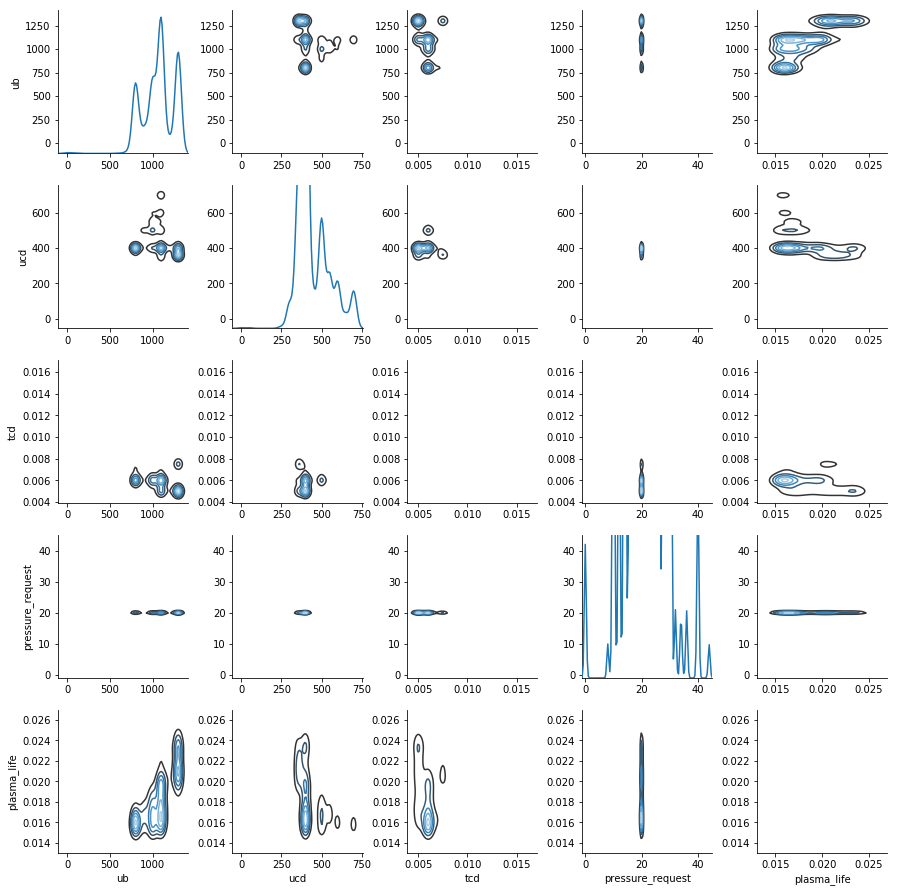

In [44]:
g = seaborn.PairGrid(longest_shots)
g.map_diag(seaborn.kdeplot)
g.map_offdiag(seaborn.kdeplot, cmap="Blues_d", n_levels=6);